
#Name: Zeel Patel

##Installing Spark

In [1]:
from pyspark.sql import SparkSession
from pyspark.sql.functions import *
from pyspark.sql.types import *

# Create Spark session with increased memory configuration
spark = SparkSession.builder \
    .appName("Airline Delay Analysis") \
    .config("spark.driver.memory", "8g") \
    .config("spark.executor.memory", "8g") \
    .config("spark.sql.execution.arrow.pyspark.enabled", "true") \
    .config("spark.sql.autoBroadcastJoinThreshold", "-1") \
    .config("spark.driver.maxResultSize", "4g") \
    .config("spark.sql.shuffle.partitions", "200") \
    .config("spark.driver.extraJavaOptions", "-XX:-UseGCOverheadLimit") \
    .getOrCreate()

sc = spark.sparkContext

# Check the Spark version
print(spark.version)



3.5.3


In [2]:
# Update environment (if needed)
# !sudo apt update

# Download and install Java
!sudo apt-get install openjdk-8-jdk-headless -qq > /dev/null

# Install Apache Spark with Hadoop
!wget -nc -q https://downloads.apache.org/spark/spark-3.5.3/spark-3.5.3-bin-hadoop3.tgz

# Unzip the folder
!tar xf spark-3.5.3-bin-hadoop3.tgz

# Install findspark library that will locate Spark on the system
!pip install -q findspark

debconf: unable to initialize frontend: Dialog
debconf: (No usable dialog-like program is installed, so the dialog based frontend cannot be used. at /usr/share/perl5/Debconf/FrontEnd/Dialog.pm line 78, <> line 3.)
debconf: falling back to frontend: Readline
debconf: unable to initialize frontend: Readline
debconf: (This frontend requires a controlling tty.)
debconf: falling back to frontend: Teletype
dpkg-preconfigure: unable to re-open stdin: 


In [3]:
# Setting the environment variables, to enable running PySpark in Colab environment.

import os
import shutil
from itertools import islice
import requests

os.environ["JAVA_HOME"] = "/usr/lib/jvm/java-8-openjdk-amd64"
os.environ["SPARK_HOME"] = "/content/spark-3.5.3-bin-hadoop3"

In [4]:
# Locate Spark in the system

import findspark
findspark.init()

###Mount Google Drive

In [5]:
# Load the Drive helper and mount
from google.colab import drive

# This will prompt for authorization.
drive.mount('/content/drive')

Mounted at /content/drive


In [6]:
import os
import shutil
from itertools import islice
import requests
import pandas as pd

pd.set_option("max_colwidth", 100)

In [7]:
def get_gcs_data (bucket_name, folder_name, file_name, path_gdrive):
    url = 'https://storage.googleapis.com/' + bucket_name + '/' + folder_name + '/' + file_name
    r = requests.get(url)
    open(path_gdrive + '/' + file_name , 'wb').write(r.content)

##Loading Data

In [8]:
bucket_name = 'msca-bdp-data-open'
folder_name = 'airlines'
file_name = ['2007.csv','2008.csv']
path_gdrive = '/content/drive/My Drive/Colab Notebooks/Big Data/Assignment 6/'

os.makedirs(path_gdrive, exist_ok=True)

for file in file_name:
    get_gcs_data (bucket_name = bucket_name,
                 folder_name = folder_name,
                 file_name = file,
                 path_gdrive = path_gdrive)
    print('Downloaded: ' + file)

Downloaded: 2007.csv
Downloaded: 2008.csv


In [10]:
!ls -f '/content/drive/My Drive/Colab Notebooks/Big Data/Assignment 6/'

2007.csv  2008.csv


In [11]:
df_2007 = spark.read.option("header", "true").csv(path_gdrive+'2007.csv')
df_2008 = spark.read.option("header", "true").csv(path_gdrive+'2008.csv')

df_2007.cache()
df_2008.cache()

DataFrame[Year: string, Month: string, DayofMonth: string, DayOfWeek: string, DepTime: string, CRSDepTime: string, ArrTime: string, CRSArrTime: string, UniqueCarrier: string, FlightNum: string, TailNum: string, ActualElapsedTime: string, CRSElapsedTime: string, AirTime: string, ArrDelay: string, DepDelay: string, Origin: string, Dest: string, Distance: string, TaxiIn: string, TaxiOut: string, Cancelled: string, CancellationCode: string, Diverted: string, CarrierDelay: string, WeatherDelay: string, NASDelay: string, SecurityDelay: string, LateAircraftDelay: string]

In [12]:
df_2007.printSchema()
df_2008.printSchema()

root
 |-- Year: string (nullable = true)
 |-- Month: string (nullable = true)
 |-- DayofMonth: string (nullable = true)
 |-- DayOfWeek: string (nullable = true)
 |-- DepTime: string (nullable = true)
 |-- CRSDepTime: string (nullable = true)
 |-- ArrTime: string (nullable = true)
 |-- CRSArrTime: string (nullable = true)
 |-- UniqueCarrier: string (nullable = true)
 |-- FlightNum: string (nullable = true)
 |-- TailNum: string (nullable = true)
 |-- ActualElapsedTime: string (nullable = true)
 |-- CRSElapsedTime: string (nullable = true)
 |-- AirTime: string (nullable = true)
 |-- ArrDelay: string (nullable = true)
 |-- DepDelay: string (nullable = true)
 |-- Origin: string (nullable = true)
 |-- Dest: string (nullable = true)
 |-- Distance: string (nullable = true)
 |-- TaxiIn: string (nullable = true)
 |-- TaxiOut: string (nullable = true)
 |-- Cancelled: string (nullable = true)
 |-- CancellationCode: string (nullable = true)
 |-- Diverted: string (nullable = true)
 |-- CarrierDelay:

In [13]:
df_2007.show(5)

+----+-----+----------+---------+-------+----------+-------+----------+-------------+---------+-------+-----------------+--------------+-------+--------+--------+------+----+--------+------+-------+---------+----------------+--------+------------+------------+--------+-------------+-----------------+
|Year|Month|DayofMonth|DayOfWeek|DepTime|CRSDepTime|ArrTime|CRSArrTime|UniqueCarrier|FlightNum|TailNum|ActualElapsedTime|CRSElapsedTime|AirTime|ArrDelay|DepDelay|Origin|Dest|Distance|TaxiIn|TaxiOut|Cancelled|CancellationCode|Diverted|CarrierDelay|WeatherDelay|NASDelay|SecurityDelay|LateAircraftDelay|
+----+-----+----------+---------+-------+----------+-------+----------+-------------+---------+-------+-----------------+--------------+-------+--------+--------+------+----+--------+------+-------+---------+----------------+--------+------------+------------+--------+-------------+-----------------+
|2007|    1|         1|        1|   1232|      1225|   1341|      1340|           WN|     2891

In [14]:
df_2007.orderBy(df_2007['ArrDelay'].desc()).show()

+----+-----+----------+---------+-------+----------+-------+----------+-------------+---------+-------+-----------------+--------------+-------+--------+--------+------+----+--------+------+-------+---------+----------------+--------+------------+------------+--------+-------------+-----------------+
|Year|Month|DayofMonth|DayOfWeek|DepTime|CRSDepTime|ArrTime|CRSArrTime|UniqueCarrier|FlightNum|TailNum|ActualElapsedTime|CRSElapsedTime|AirTime|ArrDelay|DepDelay|Origin|Dest|Distance|TaxiIn|TaxiOut|Cancelled|CancellationCode|Diverted|CarrierDelay|WeatherDelay|NASDelay|SecurityDelay|LateAircraftDelay|
+----+-----+----------+---------+-------+----------+-------+----------+-------------+---------+-------+-----------------+--------------+-------+--------+--------+------+----+--------+------+-------+---------+----------------+--------+------------+------------+--------+-------------+-----------------+
|2007|    3|        28|        3|     NA|      1545|     NA|      1900|           UA|      376

In [15]:
df_2008.show(5)

+----+-----+----------+---------+-------+----------+-------+----------+-------------+---------+-------+-----------------+--------------+-------+--------+--------+------+----+--------+------+-------+---------+----------------+--------+------------+------------+--------+-------------+-----------------+
|Year|Month|DayofMonth|DayOfWeek|DepTime|CRSDepTime|ArrTime|CRSArrTime|UniqueCarrier|FlightNum|TailNum|ActualElapsedTime|CRSElapsedTime|AirTime|ArrDelay|DepDelay|Origin|Dest|Distance|TaxiIn|TaxiOut|Cancelled|CancellationCode|Diverted|CarrierDelay|WeatherDelay|NASDelay|SecurityDelay|LateAircraftDelay|
+----+-----+----------+---------+-------+----------+-------+----------+-------------+---------+-------+-----------------+--------------+-------+--------+--------+------+----+--------+------+-------+---------+----------------+--------+------------+------------+--------+-------------+-----------------+
|2008|    1|         3|        4|   2003|      1955|   2211|      2225|           WN|      335

In [16]:
# Summary statistics for arrival and departure delays
df_2007.select("ArrDelay", "DepDelay").describe().show()

+-------+------------------+------------------+
|summary|          ArrDelay|          DepDelay|
+-------+------------------+------------------+
|  count|           7453215|           7453215|
|   mean| 10.19218057072105|11.399141744487839|
| stddev|39.307738889603094|36.141889220944975|
|    min|                -1|                -1|
|    max|                NA|                NA|
+-------+------------------+------------------+



In [17]:
df_2008.select("ArrDelay", "DepDelay").describe().show()

+-------+-----------------+------------------+
|summary|         ArrDelay|          DepDelay|
+-------+-----------------+------------------+
|  count|          7009728|           7009728|
|   mean| 8.16845238729114| 9.972570088930182|
| stddev|38.50193694882867|35.311270777552785|
|    min|               -1|                -1|
|    max|               NA|                NA|
+-------+-----------------+------------------+



##1. Locations (Origin and Dest pairs) which had the worst delays for both arrivals (ArrDelay) and departures (DepDelay) - for each year

### Top 10 Worst Delays for 2007 and 2008, together for Arrivals and Delays

In [18]:
from pyspark.sql.functions import avg, desc

# For 2007 data
worst_delays_2007 = df_2007.groupBy("Origin", "Dest") \
    .agg(avg("ArrDelay").alias("AvgArrDelay"), avg("DepDelay").alias("AvgDepDelay")) \
    .orderBy(desc("AvgArrDelay"), desc("AvgDepDelay"))

# For 2008 data
worst_delays_2008 = df_2008.groupBy("Origin", "Dest") \
    .agg(avg("ArrDelay").alias("AvgArrDelay"), avg("DepDelay").alias("AvgDepDelay")) \
    .orderBy(desc("AvgArrDelay"), desc("AvgDepDelay"))

print("Top 10 Worst Delays in 2007:")
worst_delays_2007.show(10)

print("Top 10 Worst Delays in 2008:")
worst_delays_2008.show(10)

Top 10 Worst Delays in 2007:
+------+----+-----------+-----------+
|Origin|Dest|AvgArrDelay|AvgDepDelay|
+------+----+-----------+-----------+
|   ONT| IAD|      370.0|      386.0|
|   ELP| MFE|      316.0|      307.0|
|   ACY| MYR|      252.0|      222.0|
|   JAX| CMH|      217.0|      165.0|
|   DCA| PLN|      210.0|      168.0|
|   AVP| BUF|      195.0|      201.0|
|   JFK| GSO|      181.0|      173.0|
|   GSP| RSW|      175.0|       85.0|
|   PIT| PVD|      158.0|      135.0|
|   JFK| SAV|      157.0|      130.0|
+------+----+-----------+-----------+
only showing top 10 rows

Top 10 Worst Delays in 2008:
+------+----+-----------+-----------+
|Origin|Dest|AvgArrDelay|AvgDepDelay|
+------+----+-----------+-----------+
|   CMI| SPI|      575.0|      587.0|
|   ONT| SAN|      257.0|      221.0|
|   BHM| JFK|      252.0|      210.0|
|   RIC| ORF|      227.0|      205.0|
|   ATW| DSM|      210.0|      185.0|
|   ORF| BOI|      180.0|      160.0|
|   ORF| BDL|      175.0|      150.0|
|   

### Top Worst Delays for 2007 and 2008, together for Arrivals and Delays

In [20]:
print("Top Worst Delay in 2007:")
worst_delays_2007.show(1)

print("Top 1 Worst Delay in 2008:")
worst_delays_2008.show(1)

Top Worst Delay in 2007:
+------+----+-----------+-----------+
|Origin|Dest|AvgArrDelay|AvgDepDelay|
+------+----+-----------+-----------+
|   ONT| IAD|      370.0|      386.0|
+------+----+-----------+-----------+
only showing top 1 row

Top 1 Worst Delay in 2008:
+------+----+-----------+-----------+
|Origin|Dest|AvgArrDelay|AvgDepDelay|
+------+----+-----------+-----------+
|   CMI| SPI|      575.0|      587.0|
+------+----+-----------+-----------+
only showing top 1 row



Worst Delays for 2007 (combined ArrDelay and DepDelay)

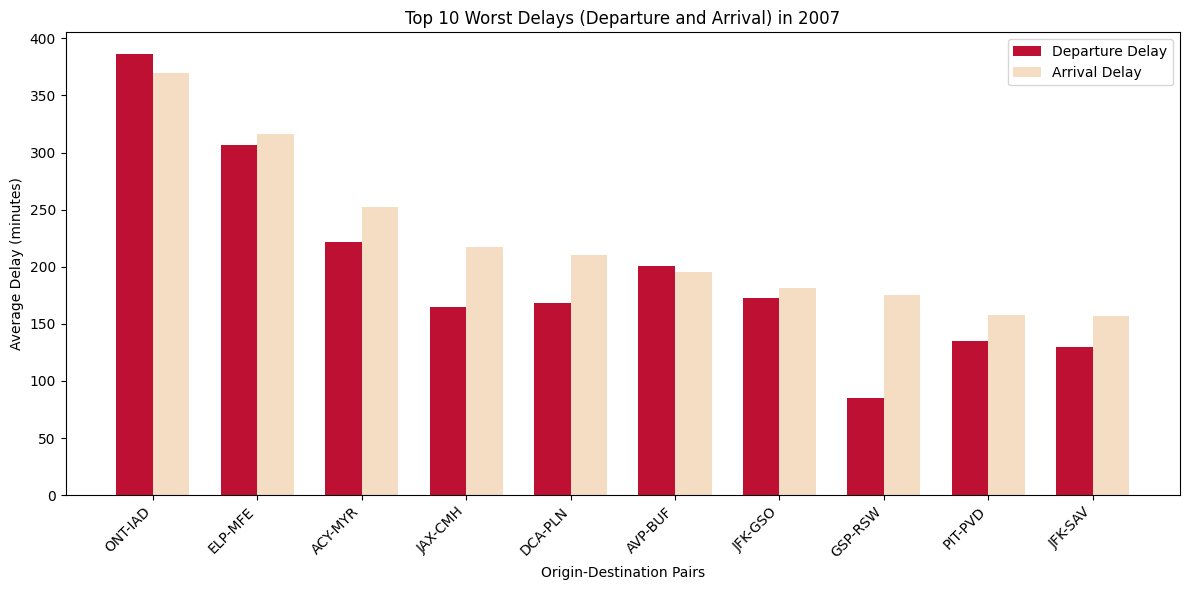

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

worst_delays_2007_pd = worst_delays_2007.limit(10).toPandas()
worst_delays_2008_pd = worst_delays_2008.limit(10).toPandas()



x_labels = worst_delays_2007_pd['Origin'] + '-' + worst_delays_2007_pd['Dest']
x = np.arange(len(x_labels))
width = 0.35

fig, ax = plt.subplots(figsize=(12, 6))
bar1 = ax.bar(x - width/2, worst_delays_2007_pd['AvgDepDelay'], width, label='Departure Delay', color='#BD1033')
bar2 = ax.bar(x + width/2, worst_delays_2007_pd['AvgArrDelay'], width, label='Arrival Delay', color='#F5DDC4')

ax.set_xlabel('Origin-Destination Pairs')
ax.set_ylabel('Average Delay (minutes)')
ax.set_title('Top 10 Worst Delays (Departure and Arrival) in 2007')
ax.set_xticks(x)
ax.set_xticklabels(x_labels, rotation=45, ha='right')
ax.legend()

plt.tight_layout()
plt.show()


Worst Delays for 2008 (combined ArrDelay and DepDelay )

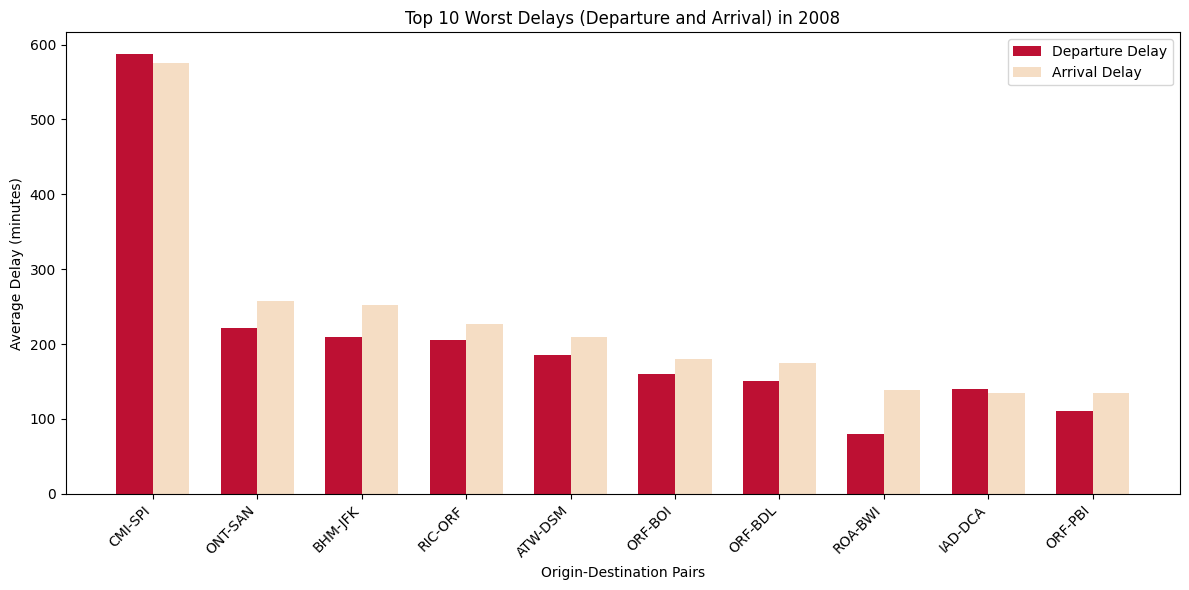

In [ ]:

x_labels = worst_delays_2008_pd['Origin'] + '-' + worst_delays_2008_pd['Dest']
x = np.arange(len(x_labels))

fig, ax = plt.subplots(figsize=(12, 6))
bar1 = ax.bar(x - width/2, worst_delays_2008_pd['AvgDepDelay'], width, label='Departure Delay', color='#BD1033')
bar2 = ax.bar(x + width/2, worst_delays_2008_pd['AvgArrDelay'], width, label='Arrival Delay', color='#F5DDC4')

ax.set_xlabel('Origin-Destination Pairs')
ax.set_ylabel('Average Delay (minutes)')
ax.set_title('Top 10 Worst Delays (Departure and Arrival) in 2008')
ax.set_xticks(x)
ax.set_xticklabels(x_labels, rotation=45, ha='right')
ax.legend()

plt.tight_layout()
plt.show()

##2. Locations (Origin and Dest pairs) which had the fewest delays for both arrivals (ArrDelay) and departures (DepDelay) - for each year

### Top 10 Fewest Delays for 2007 and 2008, together for Arrivals and Delays


In [25]:
from pyspark.sql.functions import col, avg

def locations_with_fewest_delays_separate(df, year):
    print(f"\n--- {year} Locations with Fewest Delays ---")

    df = df.withColumn("ArrDelay", col("ArrDelay").cast("double"))
    df = df.withColumn("DepDelay", col("DepDelay").cast("double"))

    filtered_df = df.na.drop(subset=["ArrDelay", "DepDelay"])

    avg_delays = filtered_df.groupBy("Origin", "Dest") \
        .agg(avg("ArrDelay").alias("AvgArrDelay"), avg("DepDelay").alias("AvgDepDelay"))

    fewest_arrival_delays = avg_delays.orderBy(col("AvgArrDelay").asc()).limit(10)
    print(f"\n--- {year} Routes with Fewest Arrival Delays ---")
    fewest_arrival_delays.show()

    fewest_departure_delays = avg_delays.orderBy(col("AvgDepDelay").asc()).limit(10)
    print(f"\n--- {year} Routes with Fewest Departure Delays ---")
    fewest_departure_delays.show()

# Calculate and display locations with fewest delays separately for arrivals and departures for 2007 and 2008
locations_with_fewest_delays_separate(df_2007, "2007")
locations_with_fewest_delays_separate(df_2008, "2008")


--- 2007 Locations with Fewest Delays ---

--- 2007 Routes with Fewest Arrival Delays ---
+------+----+-------------------+-------------------+
|Origin|Dest|        AvgArrDelay|        AvgDepDelay|
+------+----+-------------------+-------------------+
|   RIC| BUF|              -41.0|              -11.0|
|   ADK| ANC|-30.228070175438596|-11.719298245614034|
|   LFT| DCA|              -26.0|               -6.0|
|   MCO| PWM|-24.611764705882354| -1.011764705882353|
|   BWI| OAK| -23.01831501831502|  8.336996336996338|
|   TUS| OAK|-22.666666666666668| -2.210526315789474|
|   BNA| ORF|              -21.4|               -2.4|
|   PIT| CMH|              -21.0|               -7.0|
|   PVD| FLL|-20.527522935779817|  3.536697247706422|
|   LAS| BMI| -19.14666666666667|              -1.32|
+------+----+-------------------+-------------------+


--- 2007 Routes with Fewest Departure Delays ---
+------+----+-------------------+-------------------+
|Origin|Dest|        AvgArrDelay|        AvgDepD

## 3. Seasonality Analysis

### Seasonality Effects on Delays in 2007

Based on the analysis of flight delays in 2007 and 2008, it is evident that there is a seasonal trend affecting both arrival and departure delays. Delays are typically higher during the winter months, especially in December and January, likely due to increased holiday travel and adverse weather conditions. May and July also see peaks in delays, which could be associated with summer vacation travel. In contrast, delays are consistently lower during the fall months, from September to November, suggesting fewer disruptions and smoother flight operations. These insights highlight the impact of seasonal patterns on flight delays, which could be useful for airlines and passengers in planning and managing travel schedules.

In [28]:
seasonality_delays_2007 = df_2007.groupBy("Month") \
    .agg(avg("ArrDelay").alias("AvgArrDelay"), avg("DepDelay").alias("AvgDepDelay")) \
    .orderBy("Month")

seasonality_delays_2008 = df_2008.groupBy("Month") \
    .agg(avg("ArrDelay").alias("AvgArrDelay"), avg("DepDelay").alias("AvgDepDelay")) \
    .orderBy("Month")

In [29]:
seasonality_delays_2007_pd = seasonality_delays_2007.toPandas()
seasonality_delays_2008_pd = seasonality_delays_2008.toPandas()

    Month  MonthName  AvgArrDelay  AvgDepDelay
0       1    January     9.162152    10.286743
1      10    October     6.508259     7.973724
2      11   November     4.793344     7.446888
3      12   December    16.213714    16.201398
4       2   February    13.519795    14.022531
5       3      March    10.084908    11.836803
6       4      April     8.516230    10.077714
7       5        May     7.037889     8.329205
8       6       June    16.179528    16.214701
9       7       July    14.107680    14.802614
10      8     August    12.571533    13.515876
11      9  September     3.749498     6.157686


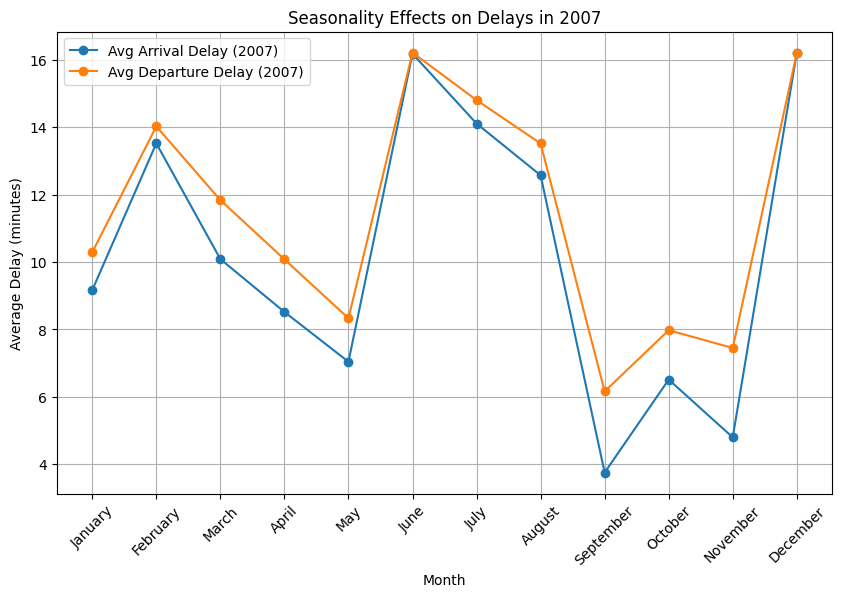

In [ ]:
import matplotlib.pyplot as plt

# Convert 'Month' column to integer type (if not already)
seasonality_delays_2007_pd['Month'] = seasonality_delays_2007_pd['Month'].astype(int)

month_labels = {
    1: 'January', 2: 'February', 3: 'March', 4: 'April', 5: 'May',
    6: 'June', 7: 'July', 8: 'August', 9: 'September',
    10: 'October', 11: 'November', 12: 'December'
}
seasonality_delays_2007_pd['MonthName'] = seasonality_delays_2007_pd['Month'].map(month_labels)

print(seasonality_delays_2007_pd[['Month', 'MonthName', 'AvgArrDelay', 'AvgDepDelay']])

seasonality_delays_2007_pd = seasonality_delays_2007_pd.sort_values(by='Month')

plt.figure(figsize=(10, 6))
plt.plot(seasonality_delays_2007_pd['MonthName'], seasonality_delays_2007_pd['AvgArrDelay'], label='Avg Arrival Delay (2007)', marker='o')
plt.plot(seasonality_delays_2007_pd['MonthName'], seasonality_delays_2007_pd['AvgDepDelay'], label='Avg Departure Delay (2007)', marker='o')
plt.xlabel('Month')
plt.ylabel('Average Delay (minutes)')
plt.title('Seasonality Effects on Delays in 2007')
plt.xticks(rotation=45)
plt.legend()
plt.grid(True)
plt.show()


The graph shows that both average arrival and departure delays are generally higher during the winter months, particularly in December and January, possibly due to holiday travel and challenging weather conditions. There is also a notable peak in delays around May and July, likely due to increased summer travel. The lowest delays are observed from September to November, indicating smoother flight operations during the fall months.








### Seasonality Effects on Delays in 2008

    Month  MonthName  AvgArrDelay  AvgDepDelay
0       1    January    10.188856    11.476096
1      10    October     0.415495     3.803488
2      11   November     2.015858     5.420469
3      12   December    16.680505    17.304380
4       2   February    13.077837    13.706226
5       3      March    11.192365    12.491269
6       4      April     6.807297     8.201133
7       5        May     5.978448     7.642741
8       6       June    13.266756    13.609818
9       7       July     9.975050    11.807545
10      8     August     6.910915     9.614753
11      9  September     0.697733     3.961819


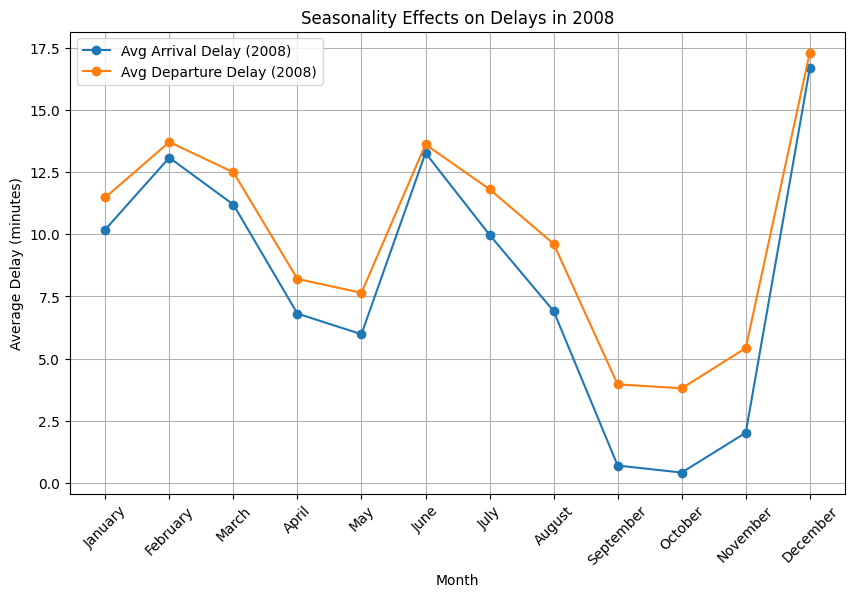

In [ ]:
seasonality_delays_2008_pd['Month'] = seasonality_delays_2008_pd['Month'].astype(int)

month_labels = {
    1: 'January', 2: 'February', 3: 'March', 4: 'April', 5: 'May',
    6: 'June', 7: 'July', 8: 'August', 9: 'September',
    10: 'October', 11: 'November', 12: 'December'
}
seasonality_delays_2008_pd['MonthName'] = seasonality_delays_2008_pd['Month'].map(month_labels)

print(seasonality_delays_2008_pd[['Month', 'MonthName', 'AvgArrDelay', 'AvgDepDelay']])

seasonality_delays_2008_pd = seasonality_delays_2008_pd.sort_values(by='Month')

plt.figure(figsize=(10, 6))
plt.plot(seasonality_delays_2008_pd['MonthName'], seasonality_delays_2008_pd['AvgArrDelay'], label='Avg Arrival Delay (2008)', marker='o')
plt.plot(seasonality_delays_2008_pd['MonthName'], seasonality_delays_2008_pd['AvgDepDelay'], label='Avg Departure Delay (2008)', marker='o')
plt.xlabel('Month')
plt.ylabel('Average Delay (minutes)')
plt.title('Seasonality Effects on Delays in 2008')
plt.xticks(rotation=45)
plt.legend()
plt.grid(True)
plt.show()


The graph shows the seasonality effects on flight delays in 2008. Both average arrival and departure delays exhibit noticeable variations throughout the year. Delays tend to be higher during the winter months of December and January, as well as in March and July, possibly due to increased travel during holiday periods and adverse weather conditions. In contrast, delays are significantly lower during the late summer and fall months, particularly from August to October, indicating smoother operations during these months.

## 4. Weekend Effects


Based on the data for 2007 and 2008, there isn't a noticeable trend regarding delays on weekends compared to weekdays:

In 2007, average delays were almost the same for the weekends when compared to weekdays:

In 2008, the weekends had a slightly higher delay.

In [ ]:
from pyspark.sql.functions import avg, when, col

weekend_effects_2007 = df_2007.withColumn(
    "DayType",
    when(col("DayOfWeek").isin(1, 7), "Weekend").otherwise("Weekday")
).groupBy("DayType") \
 .agg(avg("ArrDelay").alias("AvgArrDelay"), avg("DepDelay").alias("AvgDepDelay")) \
 .orderBy("DayType")

weekend_effects_2008 = df_2008.withColumn(
    "DayType",
    when(col("DayOfWeek").isin(1, 7), "Weekend").otherwise("Weekday")
).groupBy("DayType") \
 .agg(avg("ArrDelay").alias("AvgArrDelay"), avg("DepDelay").alias("AvgDepDelay")) \
 .orderBy("DayType")

print("Average Delays for Weekends and Weekdays in 2007:")
weekend_effects_2007.show()

print("Average Delays for Weekends and Weekdays in 2008:")
weekend_effects_2008.show()




Average Delays for Weekends and Weekdays in 2007:
+-------+------------------+------------------+
|DayType|       AvgArrDelay|       AvgDepDelay|
+-------+------------------+------------------+
|Weekday|10.097547630274647|11.181499787664146|
|Weekend|10.424626426761403|11.933830416563964|
+-------+------------------+------------------+

Average Delays for Weekends and Weekdays in 2008:
+-------+-----------------+------------------+
|DayType|      AvgArrDelay|       AvgDepDelay|
+-------+-----------------+------------------+
|Weekday|7.899869040825366| 9.598406774962475|
|Weekend|8.834680942779952|10.900758530621008|
+-------+-----------------+------------------+



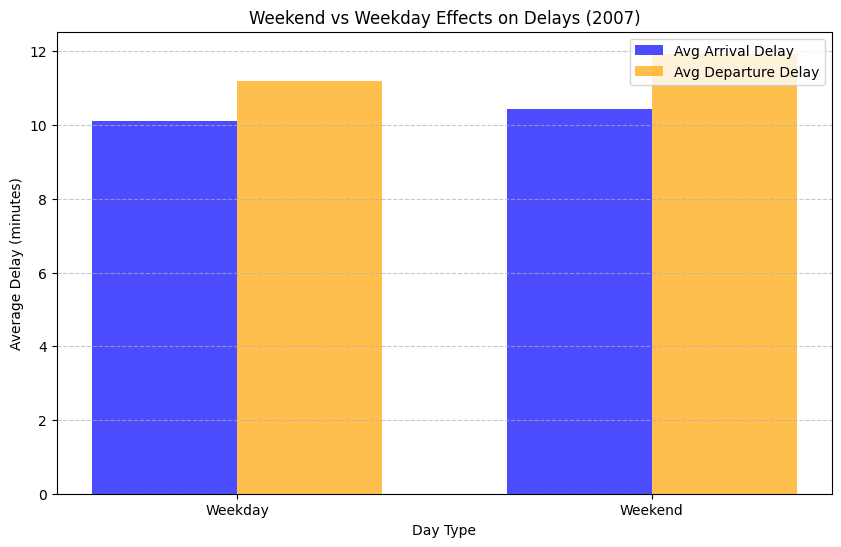

In [ ]:
weekend_avg_delays_2007 = df_2007.withColumn("Weekend", when(col("DayOfWeek").isin(1, 7), "Weekend").otherwise("Weekday")) \
    .groupBy("Weekend").agg(avg("ArrDelay").alias("AvgArrDelay"), avg("DepDelay").alias("AvgDepDelay"))

weekend_avg_delays_2007_pd = weekend_avg_delays_2007.toPandas()

plt.figure(figsize=(10, 6))
x_labels = weekend_avg_delays_2007_pd['Weekend']
x = np.arange(len(x_labels))

bar_width = 0.35
plt.bar(x - bar_width/2, weekend_avg_delays_2007_pd['AvgArrDelay'], width=bar_width, label='Avg Arrival Delay', color='blue', alpha=0.7)
plt.bar(x + bar_width/2, weekend_avg_delays_2007_pd['AvgDepDelay'], width=bar_width, label='Avg Departure Delay', color='orange', alpha=0.7)

plt.xlabel('Day Type')
plt.ylabel('Average Delay (minutes)')
plt.title('Weekend vs Weekday Effects on Delays (2007)')
plt.xticks(ticks=x, labels=x_labels)
plt.legend()
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()



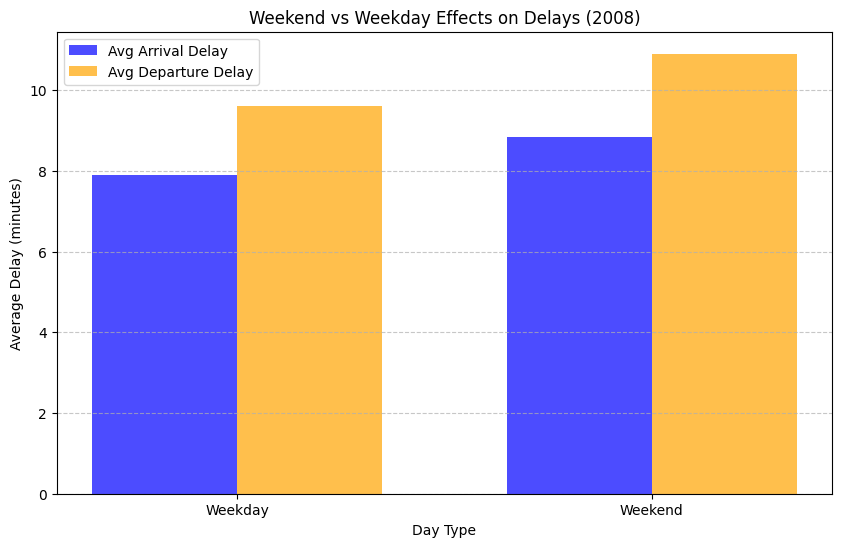

In [ ]:

weekend_avg_delays_2008 = df_2008.withColumn("Weekend", when(col("DayOfWeek").isin(1, 7), "Weekend").otherwise("Weekday")) \
    .groupBy("Weekend").agg(avg("ArrDelay").alias("AvgArrDelay"), avg("DepDelay").alias("AvgDepDelay"))

weekend_avg_delays_2008_pd = weekend_avg_delays_2008.toPandas()


plt.figure(figsize=(10, 6))
x_labels = weekend_avg_delays_2008_pd['Weekend']
x = np.arange(len(x_labels))

bar_width = 0.35

plt.bar(x - bar_width/2, weekend_avg_delays_2008_pd['AvgArrDelay'], width=bar_width, label='Avg Arrival Delay', color='blue', alpha=0.7)
plt.bar(x + bar_width/2, weekend_avg_delays_2008_pd['AvgDepDelay'], width=bar_width, label='Avg Departure Delay', color='orange', alpha=0.7)

plt.xlabel('Day Type')
plt.ylabel('Average Delay (minutes)')
plt.title('Weekend vs Weekday Effects on Delays (2008)')
plt.xticks(ticks=x, labels=x_labels)
plt.legend()
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()


In [ ]:
weekend_effects_2007_pd = weekend_effects_2007.toPandas()
weekend_effects_2008_pd = weekend_effects_2008.toPandas()

## 5. Flight Distribution throughout the Day

### Flight Distribution throughout the Day for 2007

Based on the graphs for 2007 and 2008, there is a clear trend indicating a higher concentration of both departures and arrivals during late evenings and nights compared to daytime hours. This suggests that flight activity tends to peak later in the day.


--- 2007 Time Distribution ---


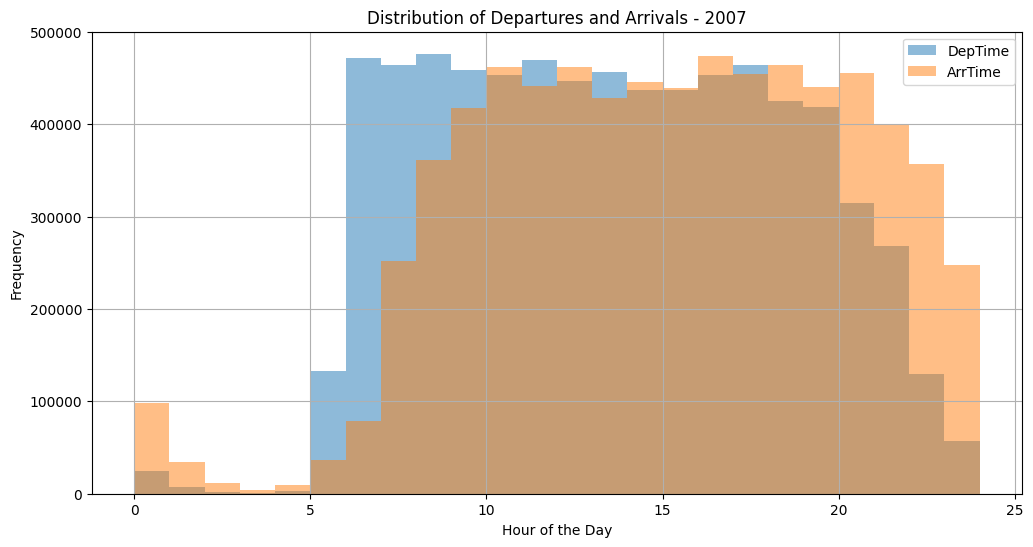

In [ ]:
import matplotlib.pyplot as plt

def time_distribution(df, year):
    print(f"\n--- {year} Time Distribution ---")

    filtered_df = df.filter((col("DepTime").isNotNull()) & (col("ArrTime").isNotNull()) &
                            (col("DepTime") != "NA") & (col("ArrTime") != "NA"))

    df_pandas = filtered_df.select("DepTime", "ArrTime").toPandas()
    df_pandas["DepTime"] = pd.to_numeric(df_pandas["DepTime"], errors='coerce').dropna().astype(int)
    df_pandas["ArrTime"] = pd.to_numeric(df_pandas["ArrTime"], errors='coerce').dropna().astype(int)

    plt.figure(figsize=(12, 6))
    plt.hist(df_pandas["DepTime"] // 100, bins=24, alpha=0.5, label="DepTime")
    plt.hist(df_pandas["ArrTime"] // 100, bins=24, alpha=0.5, label="ArrTime")
    plt.xlabel("Hour of the Day")
    plt.ylabel("Frequency")
    plt.title(f"Distribution of Departures and Arrivals - {year}")
    plt.legend()
    plt.grid(True)
    plt.show()

time_distribution(df_2007, "2007")


### Flight Distribution throughout the Day for 2008


--- 2008 Time Distribution ---


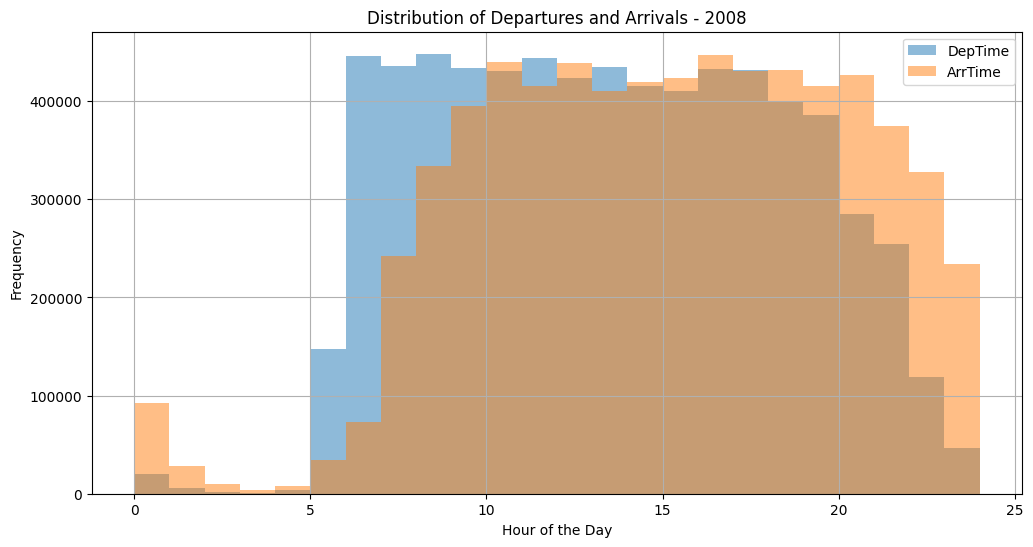

In [ ]:
time_distribution(df_2008, "2008")

##6. Worst Delays at certain times of the day

### Actual Time vs the Delay and Identify Worst Delays by Time of Day for 2007

The analysis of delays for 2007 and 2008 shows that most delays occur during red-eye flights, with a significant peak around **3 AM** for both years. This indicates that early morning hours, particularly around **3 AM**, experience the most disruption, likely due to compounding delays from previous flights or limited airport operations during late night and early morning hours.


--- 2007 Average Delays by Time of Day ---


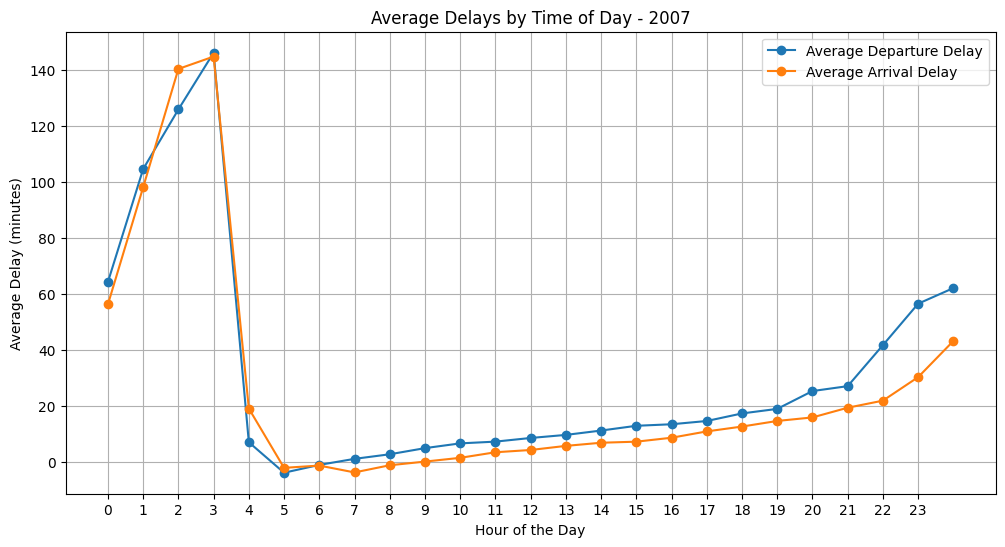

In [ ]:
def delay_by_time_of_day(df, year):
    print(f"\n--- {year} Average Delays by Time of Day ---")

    time_delays = df.withColumn("DepHour", (col("DepTime") / 100).cast("int")) \
                    .withColumn("ArrHour", (col("ArrTime") / 100).cast("int"))

    dep_delay_by_hour = time_delays.groupBy("DepHour") \
                                   .agg(avg("DepDelay").alias("AvgDepDelay")) \
                                   .orderBy("DepHour") \
                                   .toPandas()

    arr_delay_by_hour = time_delays.groupBy("ArrHour") \
                                   .agg(avg("ArrDelay").alias("AvgArrDelay")) \
                                   .orderBy("ArrHour") \
                                   .toPandas()

    plt.figure(figsize=(12, 6))
    plt.plot(dep_delay_by_hour["DepHour"], dep_delay_by_hour["AvgDepDelay"], label="Average Departure Delay", marker='o')
    plt.plot(arr_delay_by_hour["ArrHour"], arr_delay_by_hour["AvgArrDelay"], label="Average Arrival Delay", marker='o')
    plt.xlabel("Hour of the Day")
    plt.ylabel("Average Delay (minutes)")
    plt.title(f"Average Delays by Time of Day - {year}")
    plt.xticks(range(24))
    plt.legend()
    plt.grid(True)
    plt.show()

delay_by_time_of_day(df_2007, "2007")


### Actual Time vs Delay and Identify Worst Delays by Time of Day for 2008


--- 2008 Average Delays by Time of Day ---


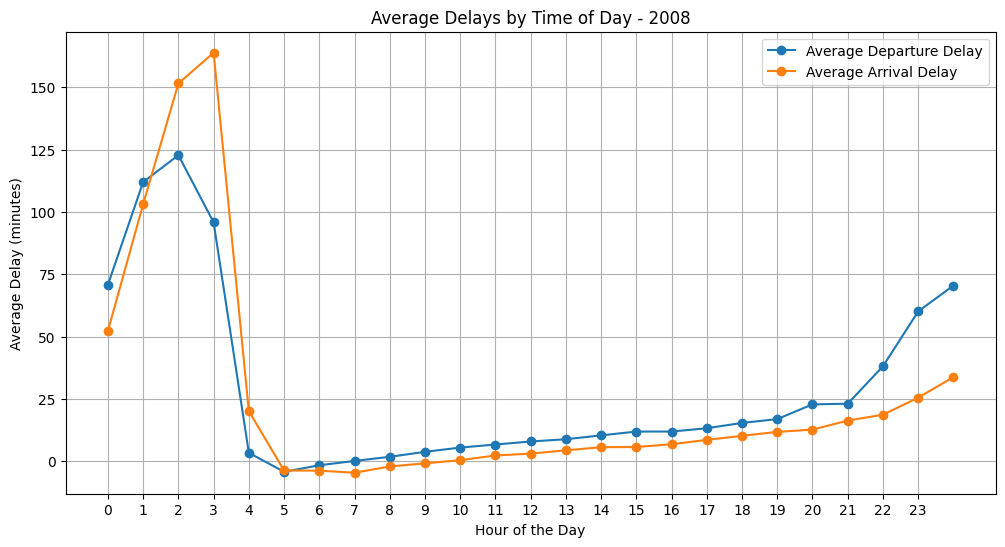

In [ ]:
delay_by_time_of_day(df_2008, "2008")

### Scheduled Time vs Delay for the year 2007


--- 2007 Comparison of Scheduled vs Actual Times ---


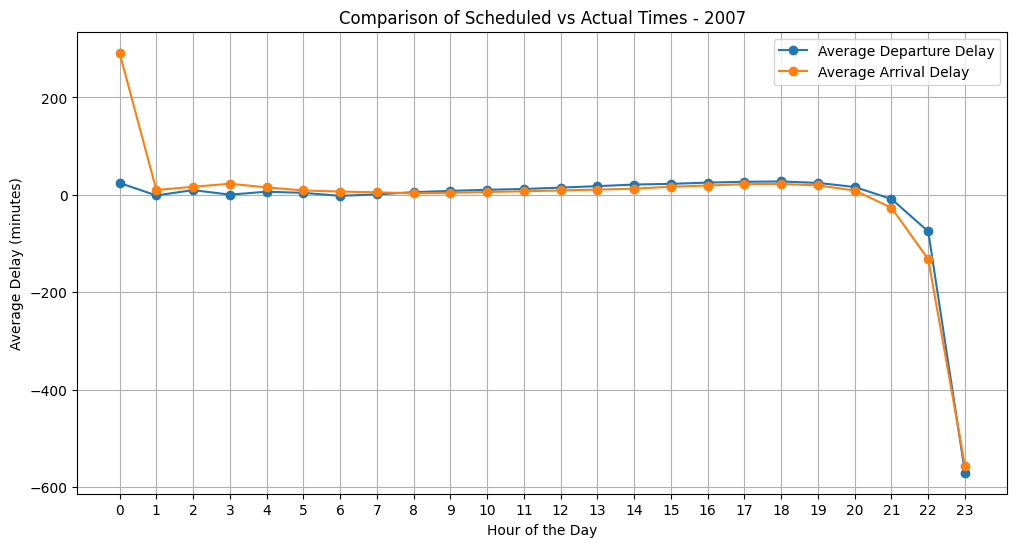

In [32]:
def compare_scheduled_vs_actual(df, year):
    print(f"\n--- {year} Comparison of Scheduled vs Actual Times ---")

    filtered_df = df.filter((col("DepTime").isNotNull()) & (col("ArrTime").isNotNull()) &
                            (col("CRSDepTime").isNotNull()) & (col("CRSArrTime").isNotNull()) &
                            (col("DepTime") != "NA") & (col("ArrTime") != "NA") &
                            (col("CRSDepTime") != "NA") & (col("CRSArrTime") != "NA"))

    time_delays = filtered_df.withColumn("DepHour", (col("CRSDepTime") / 100).cast("int")) \
                             .withColumn("ArrHour", (col("CRSArrTime") / 100).cast("int")) \
                             .withColumn("DepDelay", (col("DepTime") - col("CRSDepTime"))) \
                             .withColumn("ArrDelay", (col("ArrTime") - col("CRSArrTime")))

    dep_delay_by_hour = time_delays.groupBy("DepHour") \
                                   .agg(avg("DepDelay").alias("AvgDepDelay")) \
                                   .orderBy("DepHour") \
                                   .toPandas()

    arr_delay_by_hour = time_delays.groupBy("ArrHour") \
                                   .agg(avg("ArrDelay").alias("AvgArrDelay")) \
                                   .orderBy("ArrHour") \
                                   .toPandas()

    plt.figure(figsize=(12, 6))
    plt.plot(dep_delay_by_hour["DepHour"], dep_delay_by_hour["AvgDepDelay"], label="Average Departure Delay", marker='o')
    plt.plot(arr_delay_by_hour["ArrHour"], arr_delay_by_hour["AvgArrDelay"], label="Average Arrival Delay", marker='o')
    plt.xlabel("Hour of the Day")
    plt.ylabel("Average Delay (minutes)")
    plt.title(f"Comparison of Scheduled vs Actual Times - {year}")
    plt.xticks(range(24))
    plt.legend()
    plt.grid(True)
    plt.show()

compare_scheduled_vs_actual(df_2007, "2007")

### Scheduled Time vs Delay for the year 2008


--- 2008 Comparison of Scheduled vs Actual Times ---


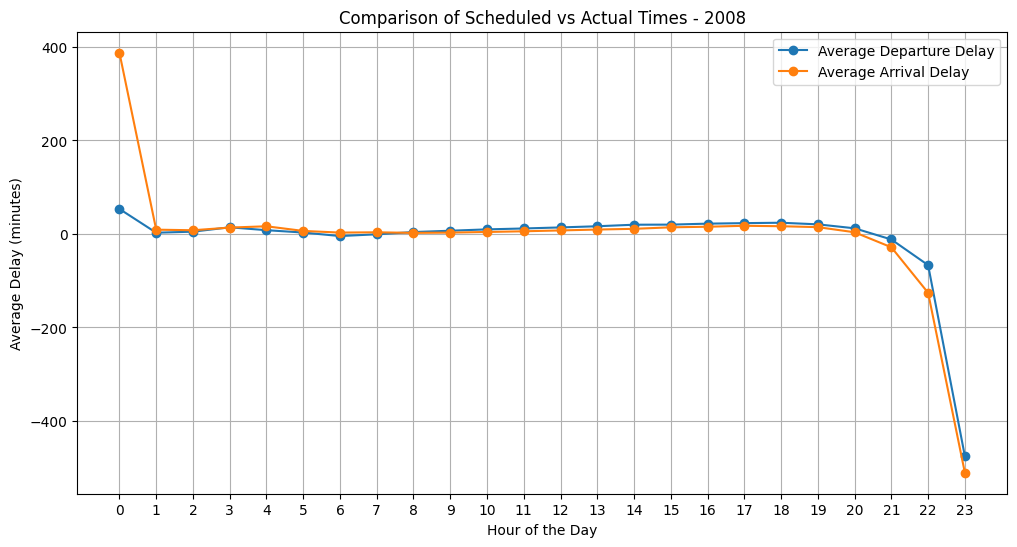

In [33]:
compare_scheduled_vs_actual(df_2008, "2008")